In [1]:
#Load libraries
import math
import multiprocessing as mp
import os

import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
#import wandB
import wandb
from tqdm import tqdm

#custom libary
import MasterThesis.preprocessing as DP
from MasterThesis import EDA

/media/omar/storage/gdrive/Maestria/MasterThesis/MasterThesis/preprocessing.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
#  Load metadata
metadata = pd.read_csv("/media/omar/storage/gdrive/Maestria/Datasets/metadata.csv")
#metadata["Image"] = metadata["Image"].str.replace(".npy", ".npz")
#metadata = pd.read_csv("/media/omar/storage/gdrive/Maestria/Theses/Preprocessing/metadata_raw_images.csv")
#metadata = metadata.query("Patch == '18NTN'")
print(metadata.shape)
metadata.head()

(59730, 10)


,Id,Elevation,Image,Mask,non_agricultural(km2),agricultural_frontier(km2),legal_exclusions(km2),non_agricultural,legal_exclusions,agricultural_frontier
0,18188500131913,"18NTN/18NTN_8_5/(0, 0)/elevation.tif","18NTN/18NTN_8_5/(0, 0)/chip.npy","18NTN/18NTN_8_5/(0, 0)/mask.tif",0.399,0.601,0.0,1,0,1
1,1818850100131913,"18NTN/18NTN_8_5/(0, 100)/elevation.tif","18NTN/18NTN_8_5/(0, 100)/chip.npy","18NTN/18NTN_8_5/(0, 100)/mask.tif",0.794,0.206,0.0,1,0,1
2,1818850200131913,"18NTN/18NTN_8_5/(0, 200)/elevation.tif","18NTN/18NTN_8_5/(0, 200)/chip.npy","18NTN/18NTN_8_5/(0, 200)/mask.tif",0.778,0.222,0.0,1,0,1
3,1818850300131913,"18NTN/18NTN_8_5/(0, 300)/elevation.tif","18NTN/18NTN_8_5/(0, 300)/chip.npy","18NTN/18NTN_8_5/(0, 300)/mask.tif",1.000,0.000,0.0,1,0,1
4,1818850400131913,"18NTN/18NTN_8_5/(0, 400)/elevation.tif","18NTN/18NTN_8_5/(0, 400)/chip.npy","18NTN/18NTN_8_5/(0, 400)/mask.tif",1.000,0.000,0.0,1,0,0


In [7]:
# path to image and masks
path_to_label = "/media/omar/storage/gdrive/Maestria/Datasets/LabelsGeoTiffv2/"
path_to_images = "/media/omar/storage/gdrive/Maestria/Datasets/Dataset/"
path_to_elevations = "/media/omar/storage/gdrive/Maestria/Datasets/Elevations/"
path_to_time_series_images = "/media/omar/storage/gdrive/Maestria/Datasets/Sentinel2_time_images/"
select_classes = ["non_agricultural_area", "legal_exclusions", "agricultural_frontier"]

In [4]:
EDA.visualize_image_bands(path_to_time_series_images, metadata)

FileNotFoundError: [Errno 2] No such file or directory: '/media/omar/storage/gdrive/Maestria/Datasets/Sentinel2_time_images/18NTN/18NTN_8_5/(0, 200)/chip.npy'

### Pixel colors distribution

I have decided to clip images to the rage [0,6000]

In [ ]:
# This function plot pixel histogram for each band
def pixel_histogram(path_to_images, metadata, sample=20, clip=None):

    """
    This function plots histogram and basic statistics for each band.
    This function assums that images are stored in .npz format

    Arguments:
        path_to_images: string
            path to the root folder where images are stroed
        metadata: data frame
            dataframe with the name of each image
        sample: int
            number of images to load and plot
        clip: int, default=None
            value to clip pixel images
    """

    images = np.array([EDA.read_numpy_image(img) for img in path_to_images + metadata.head(sample).Image])

    if clip:
        images = np.clip(images, 0, clip)

    print("------Statistics for all Bands------")
    print(f"Pixel Mean={images.mean().round(3)}")
    print(f"Pixel Min={images.min()}")
    print(f"Pixel Max={images.max()}")
    print("------------------------------------")

    i = 0
    bands = ["Red", "Green", "Blue", "y"]
    fig, axs = plt.subplots(2, 3, figsize=(10, 7))
    for img, ax in zip(images.transpose(1, 0, 2, 3)[:3], axs.flatten()[:3]):
        sns.histplot(x=img.ravel(), ax=ax, color=bands[i])
        ax.set_xlabel("Pixel Value")
        ax.legend(
            [f"Band: {bands[i]} \n Median:{np.median(img).round(2)} \n Min:{img.min()}, \n Max:{img.max()}"],
            fontsize=10,
        )

        ax.ticklabel_format(style='sci',scilimits=(0,0),axis='y')
        i += 1


    clip = 2000
    if clip:
        images = np.clip(images, 0, clip)

    print("------Statistics for all Bands------")
    print(f"Pixel Mean={images.mean().round(3)}")
    print(f"Pixel Min={images.min()}")
    print(f"Pixel Max={images.max()}")
    print("------------------------------------")

    i = 0
    bands = ["Red", "Green", "Blue", "y"]
    for img, ax in zip(images.transpose(1, 0, 2, 3)[:3], axs.flatten()[3:]):
        sns.histplot(x=img.ravel(), ax=ax, color=bands[i])
        ax.set_xlabel("Pixel Value")
        ax.legend(
            [f"Band: {bands[i]} \n Median:{np.median(img).round(2)} \n Min:{img.min()}, \n Max:{img.max()}"],
            fontsize=10,
        )

        ax.ticklabel_format(style='sci',scilimits=(0,0),axis='y')
        i += 1

    fig.tight_layout()
    plt.show()

In [9]:
# Clipped images
pixel_histogram(path_to_images, metadata.sample(frac=1, random_state=42), sample=1000, clip=None)

NameError: name 'pixel_histogram' is not defined

In [ ]:
# Clipped images
pixel_histogram(path_to_images, metadata.sample(frac=1, random_state=42), sample=1000, clip=2000)

In [ ]:
#plot images without any filter
EDA.pixel_histogram_with_image(path_to_time_series_images, metadata.head(100).sample(10), 5, scale_factor=2500, cloud_mask=False, clip=2500)

In [ ]:
#Plot images applying a filter
EDA.pixel_histogram_with_image(path_to_time_series_images, metadata, 5, scale_factor=2500, cloud_mask=True, clip=2500)

------Statistics of RGB Bands------
Pixel Mean=1566.077
Pixel Min=305
Pixel Max=2000
------------------------------------


/media/omar/storage/gdrive/Maestria/MasterThesis/MasterThesis/EDA.py:335: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


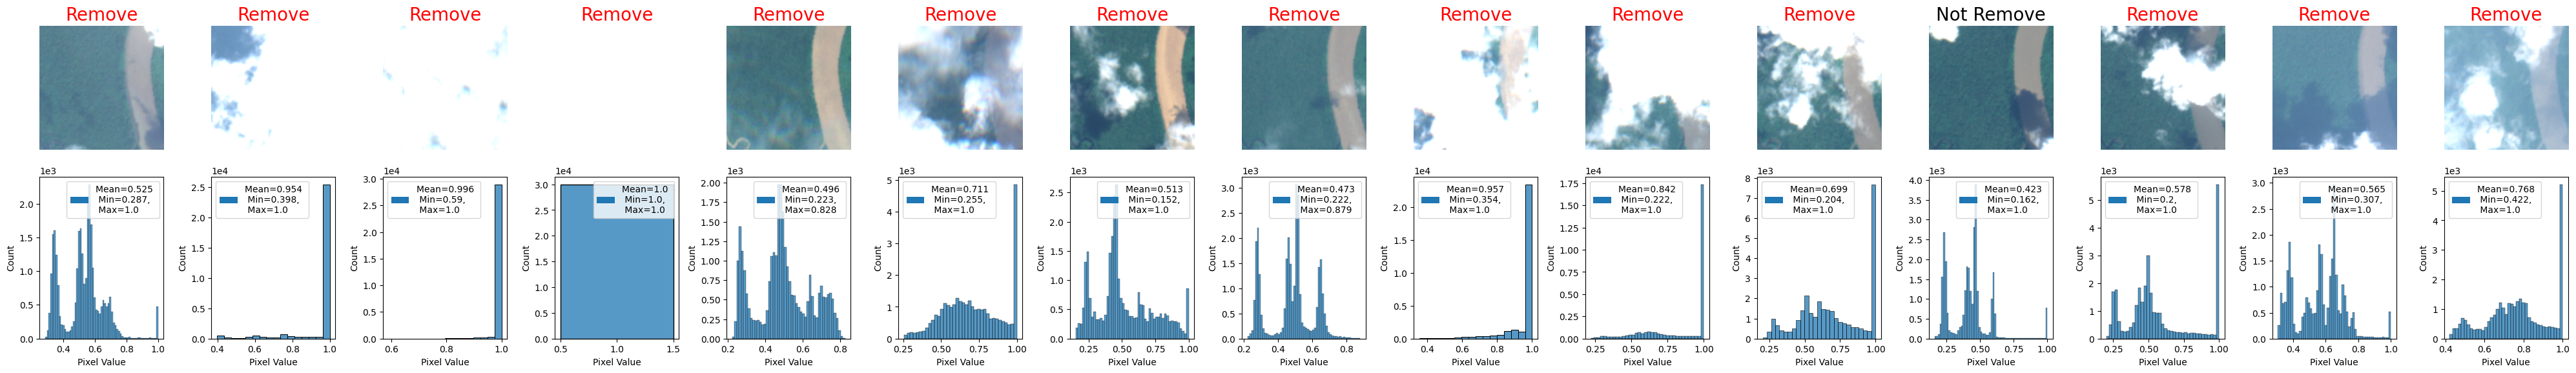

In [ ]:
EDA.pixel_histogram_and_filtered_image(path_to_time_series_images, metadata, 15, scale_factor=2000, clip=2000, threshold=0.47, figsize=(40, 6))

### **Label Definition**


* ***Agricultural_frontier:***  This areas are created from the map created by CORINE land cover (IDEAM, 2014) which are complemented with the areas reported by UPRA and the natural forest layer at 2010 (IDEAM, 2016). The areas covered in this labels include:

    * Agricultur lands
    * Grazing Areas
    * water 
    * production forestry
* ***non_agricultural_area***: No Agricultural Area

* ***lega_exclusions***: Exclusion area corresond to the terrain where agricultural activities are forbidden 

In [15]:
query = ["((legal_exclusions == 0) and (non_agricultural == 0) and (agricultural_frontier == 1)) |"
        "((legal_exclusions == 0) and (non_agricultural == 1) and (agricultural_frontier == 0))"]

query = ["((legal_exclusions == 0) and (non_agricultural == 1) and (agricultural_frontier == 1))"]

metadata = pd.read_csv("/media/omar/storage/gdrive/Maestria/Datasets/metadata.csv")
metadata = metadata.query(query[0])

In [16]:
from typing import List, Tuple

In [17]:
# helper function for data visualization#
def visualize_images_masks_elevation(
    path_to_label: str,
    path_to_images: str,
    path_to_elevations:str, 
    metadata: pd.DataFrame,
    class_names: List,
    area: Tuple = None,
    n: int = 5,
    figsize: Tuple = (10, 5),
    brightness: float = 0.0,
    cmap: dict = None,
    scaling: int = 2000,
):

    """
    Plots RGB images and labels. If images come with extra temporal
    information, they must have the shape (T,C,W,H), otherwise
    they should have the shape (C,W,H).

    Argument:
        path_to_label: string
            path to labels
        path_to_images: string
            path to images
        metadata: data frame
            dataframe with the name of each image and label
        class_names: List
            name of the classes
        area: Tuple, default=None
            columns to get the area covered by the classes
        n: int
            number of images to plot
        figsize: tuple
            matplotlib figure size
        brightness: float, default=0
            factor to add brightness to plotted images
        scaling: int
            factor to clip and normalize RGB images
    """

    if cmap is None:
        cmap = {i: [np.random.random(), np.random.random(), np.random.random(), 1] for i in range(len(class_names))}

    labels_map = {i: name for i, name in enumerate(class_names)}

    patches = [mpatches.Patch(color=cmap[i], label=labels_map[i]) for i in cmap]

    fig, ax = plt.subplots(3, n, figsize=figsize)

    for i in range(n):
        img = EDA.read_numpy_image(path_to_images + metadata["Image"].values[i])
        label = EDA.read_geotiff_image(path_to_label + metadata["Mask"].values[i])
        elevation = EDA.read_geotiff_image(path_to_elevations + metadata["Elevation"].values[i])
        ax[0, i].imshow(np.clip(img[0:3].transpose(1, 2, 0), 0, scaling) / scaling + brightness)
        ax[1, i].imshow(label)
        ax[2, i].imshow(elevation)

        arrayShow = np.array([[cmap[i] for i in j] for j in label])
        ax[1, i].imshow(arrayShow)
        plt.legend(
            handles=patches,
            bbox_to_anchor=(1.05, 1),
            loc=2,
            borderaxespad=0.0,
            markerscale=30,
            fontsize="xx-large",
        )

        ax[0, i].axis("off")
        ax[1, i].axis("off")
        ax[2, i].axis("off")

        if area:
            title = metadata[area].iloc[i].to_dict()

            s = ""
            for i_, j_ in title.items():
                s += i_ + ":" + str(j_) + " \n"
            ax[1, i].set_title(s)

    return fig

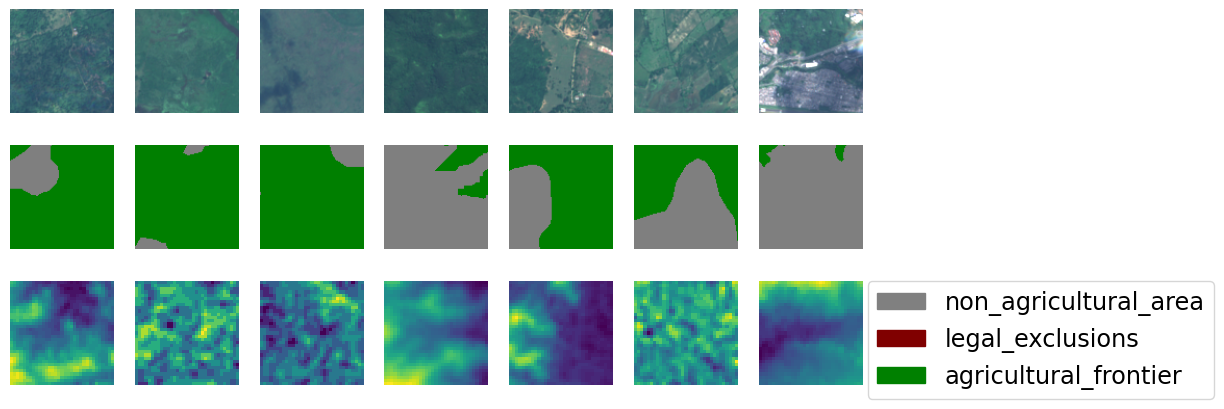

In [25]:
cmap = {0: [0.5, 0.5, 0.5, 1], 1: [0.5, 0.0, 0.0, 1], 2: [0.0, 0.5, 0.0, 1]}
fig = visualize_images_masks_elevation(
    path_to_label,
    path_to_images,
    path_to_elevations,
    metadata.sample(10),
    n=7,
    figsize=(11, 5),
    class_names=select_classes,
    scaling=2000,
    cmap=cmap
)

In [19]:
EDA.label_pixel_distributio(path_to_label, metadata, select_classes=select_classes)

 13%|█▎        | 4037/30584 [00:09<01:02, 426.38it/s] 


SystemError: <built-in function Open> returned a result with an error set

### Analyze cloudy images

In [108]:
#Defines Paths
path_to_data = "/media/omar/storage/gdrive/Maestria/Datasets/"
path_to_iamges = f"{path_to_data}Dataset"
path_to_label_v2 = f"{path_to_data}LabelsGeoTiffv2/"

In [111]:
metadata = pd.read_csv(f"{path_to_data}LabelsGeoTiffv2/metadata.csv")
#metadata = pd.read_csv("/media/omar/storage/gdrive/Maestria/Theses/Preprocessing/metadata_raw_images.csv")
print(metadata.shape)
metadata.head()

(59730, 3)


,Id,Image,Mask
0,18188500131913,"18NTN/18NTN_8_5/(0, 0)/chip.npy","18NTN/18NTN_8_5/(0, 0)/mask.tif"
1,1818850100131913,"18NTN/18NTN_8_5/(0, 100)/chip.npy","18NTN/18NTN_8_5/(0, 100)/mask.tif"
2,1818850200131913,"18NTN/18NTN_8_5/(0, 200)/chip.npy","18NTN/18NTN_8_5/(0, 200)/mask.tif"
3,1818850300131913,"18NTN/18NTN_8_5/(0, 300)/chip.npy","18NTN/18NTN_8_5/(0, 300)/mask.tif"
4,1818850400131913,"18NTN/18NTN_8_5/(0, 400)/chip.npy","18NTN/18NTN_8_5/(0, 400)/mask.tif"


In [112]:
def simple_cloud_mask_filter(image, threshold=0.23):
    """
    This function filter images based on a given threshold

    Arguments:
        image (C,W,H):numpy array
            Time series images
        scale_factor: flaot
            Factor to sacles images
        clip: int
            upper bount value to clip images
        threshold: float
            value to filter out cloudy images.
    """

    img = np.clip(image[:3], 0, 2000)/2000
    if np.mean(img) < threshold:
        return ("Not Remove", image)
    else:
        return ("Remove", image)

In [117]:
clody_img = []
no_clody_img = []

for _, data in tqdm(metadata.iterrows()):

    img = EDA.read_numpy_image(f"{path_to_images}{data.Image}")
    msg, img = simple_cloud_mask_filter(img)
    if msg == "Remove":
        clody_img.append({"Image":data.Image, "Mask":data.Mask})
    else:
        no_clody_img.append({"Image":data.Image, "Mask":data.Mask})

59730it [00:50, 1171.70it/s]


In [118]:
clody_img = pd.DataFrame(clody_img)
no_clody_img = pd.DataFrame(no_clody_img)

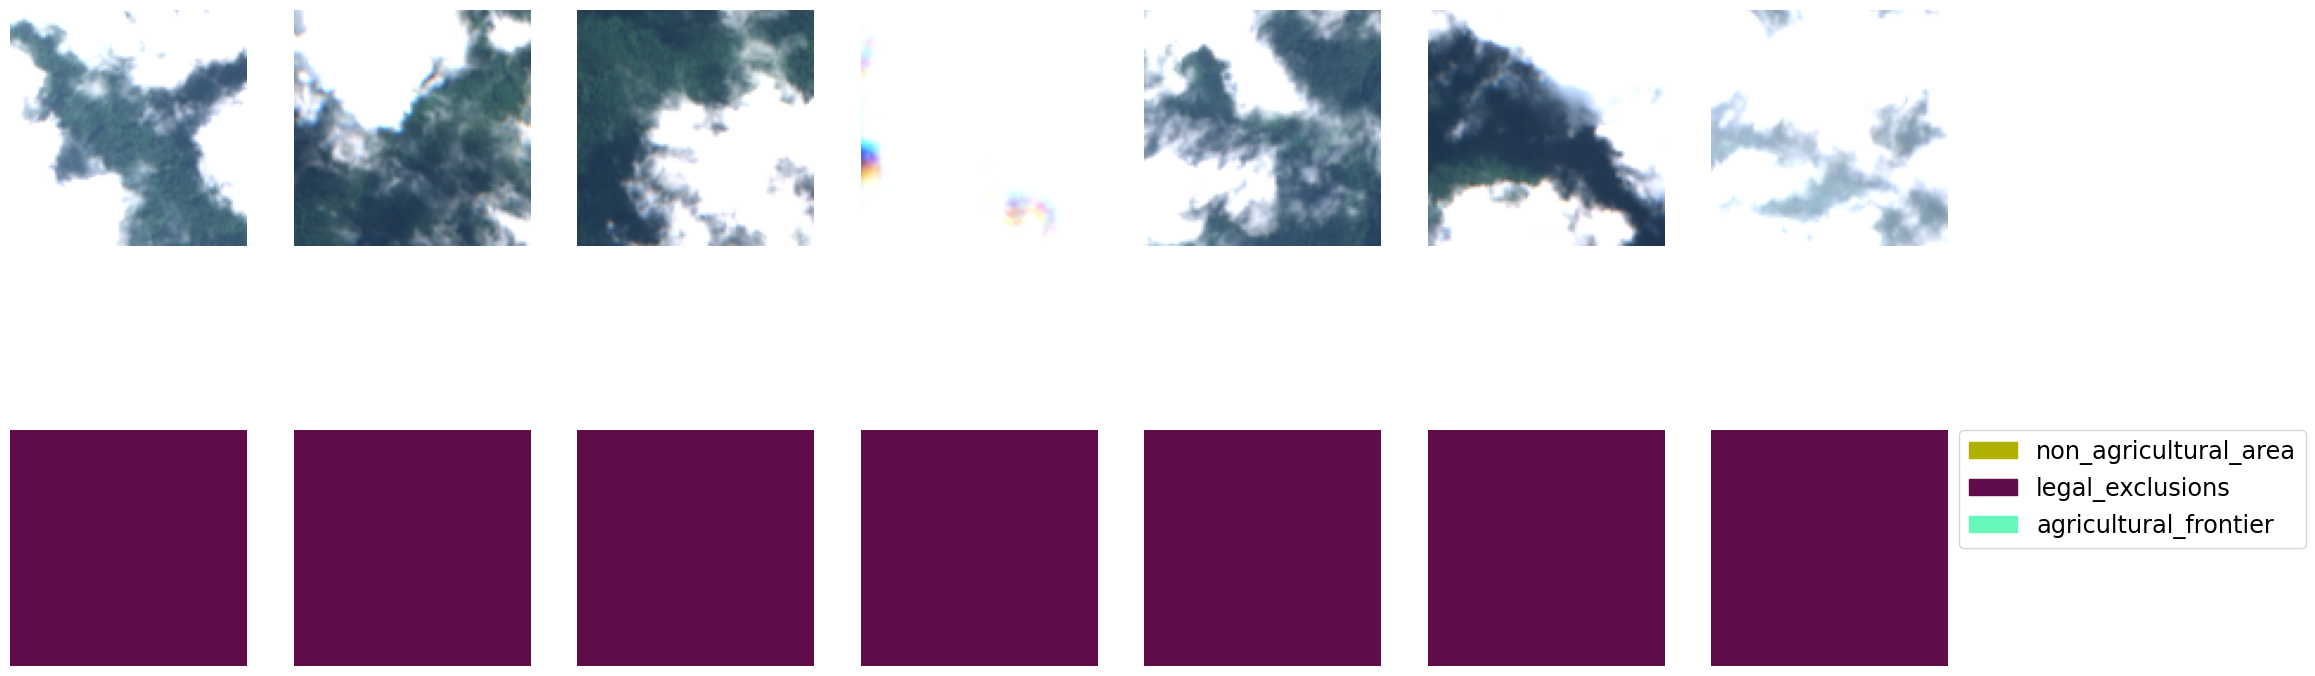

In [129]:
fig = EDA.visualize_images_and_masks(path_to_label_v2, path_to_images, clody_img.head(50), select_classes, brightness=0.0, n=7, figsize=(25, 10))

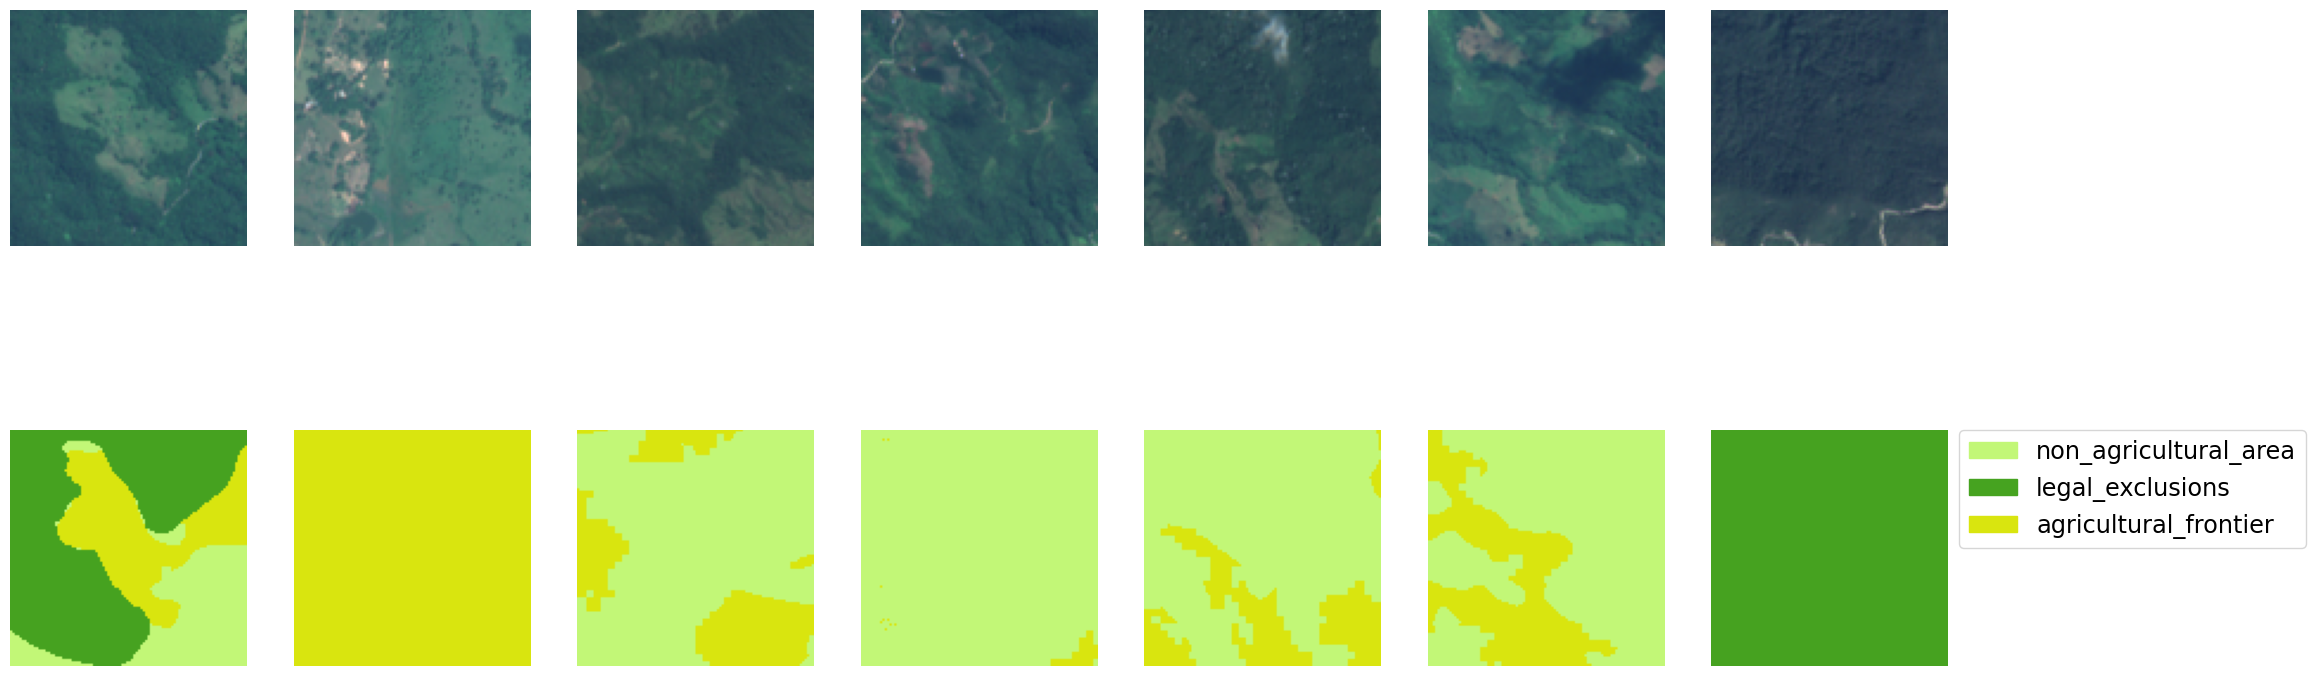

In [123]:
fig = EDA.visualize_images_and_masks(path_to_label_v2, path_to_images, no_clody_img.sample(50), select_classes, brightness=0.0, n=7, figsize=(25, 10))

### Cleaning corrupted labels and files

In [ ]:
from MasterThesis.preprocessing import remove_corruped_labels
import re
import shutil

In [ ]:
## Defines Paths
path_to_data = "/media/omar/storage/gdrive/Maestria/Datasets/GeoDataset/"
path_to_label_v2 = f"{path_to_data}LabelsGeoTiffv2/"

In [ ]:
metadata = pd.read_csv(f"{path_to_data}LabelsGeoTiffv2/metadata.csv")
raw_metadata = pd.read_csv(f"{path_to_data}Dataset/metadata.csv")
print(raw_metadata.shape)
print(metadata.shape)

In [ ]:
def remove_empty_folders(path_to_folder, metadata, raw_metadata):

    for _, data in raw_metadata.iterrows():

        if data.Id not in metadata.Id.tolist():
            
            if os.path.isdir(f"{path_to_folder}{data.Image}"):
                print("folder must be deleted", data.Id, data.Image)
                shutil.rmtree(f"{path_to_folder}{data.Image}")
    
#remove_empty_folders(path_to_label_v2, metadata, raw_metadata, "Image")

### Visualize Images and Labels and Elevations

In [ ]:
## Defines Paths
path_to_data = "/media/omar/storage/gdrive/Maestria/Datasets/"
path_to_label_v2 = f"{path_to_data}LabelsGeoTiffv2/"
path_to_images = f"{path_to_data}Dataset/"
path_to_elevations = f"{path_to_data}Elevations/"

In [ ]:
query = [
    "((legal_exclusions == 1) and (non_agricultural == 0) and (agricultural_frontier == 1)) "
]

metadata = pd.read_csv("/media/omar/storage/gdrive/Maestria/Datasets/metadata.csv")
metadata = metadata.query(query[0])
metadata.head()

In [ ]:
from typing import List, Tuple

# helper function for data visualization#
def visualize_images_and_masks(
    path_to_label: str,
    path_to_images: str,
    metadata: pd.DataFrame,
    class_names: List,
    path_to_elevation: str = None,
    area: Tuple = None,
    n: int = 5,
    figsize: Tuple = (10, 5),
    brightness: float = 0.0,
    cmap: dict = None,
):

    """
    Plots RGB images and labels. If images come with extra temporal
    information, they must have the shape (T,C,W,H), otherwise
    they should have the shape (C,W,H).

    Argument:
        path_to_label: string
            path to labels
        path_to_images: string
            path to images
        metadata: data frame
            dataframe with the name of each image and label
        class_names: List
            name of the classes
        area: Tuple, default=None
            columns to get the area covered by the classes
        n: int
            number of images to plot
        figsize: tuple
            matplotlib figure size
        brightness: float, default=0
            factor to add brightness to plotted images
    """

    if cmap is None:
        cmap = {i: [np.random.random(), np.random.random(), np.random.random(), 1] for i in range(len(class_names))}

    labels_map = {i: name for i, name in enumerate(class_names)}

    patches = [mpatches.Patch(color=cmap[i], label=labels_map[i]) for i in cmap]

    if path_to_elevation:
        m = 3
    else:
        m = 2

    fig, ax = plt.subplots(m, n, figsize=figsize)

    for i in range(n):
        img = EDA.read_numpy_image(path_to_images + metadata["Image"].values[i])
        label = EDA.read_geotiff_image(path_to_label + metadata["Mask"].values[i])

        if path_to_elevation:
            elevation = EDA.read_geotiff_image(path_to_elevation + metadata["Elevation"].values[i])

        ax[0, i].imshow(np.clip(img[0:3].transpose(1, 2, 0), 0, 6000) / 6000 + brightness)
        ax[1, i].imshow(label)

        if path_to_elevation:
            ax[2, i].imshow(elevation)

        arrayShow = np.array([[cmap[i] for i in j] for j in label])
        ax[1, i].imshow(arrayShow)
        plt.legend(
            handles=patches,
            bbox_to_anchor=(1.05, 1),
            loc=2,
            borderaxespad=0.0,
            markerscale=30,
            fontsize="xx-large",
        )

        ax[0, i].axis("off")
        ax[1, i].axis("off")

        if path_to_elevations:
            ax[2, i].axis("off")

        if area:
            title = metadata[area].iloc[i].to_dict()

            s = ""
            for i_, j_ in title.items():
                s += i_ + ":" + str(j_) + " \n"

            ax[1, i].set_title(s)

    return fig

In [ ]:
cmap = {0: [0.3, 0.5, 0.6, 1], 1: [0.5, 0.0, 0.0, 1], 2: [0.0, 0.5, 0.0, 1]}
class_names = ["Non-Agricultural Area", "Legal Exclusion", "Agricultural Frontier"]

fig = visualize_images_and_masks(
    path_to_label_v2,
    path_to_images,
    metadata.sample(10),
    class_names,
    path_to_elevation=path_to_elevations,
    brightness=0.15,
    cmap=cmap,
    n=5
)

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(25, 10))

for i, (idx, data) in enumerate(metadata.head(5).iterrows()):

    img = EDA.read_numpy_image(f"{path_to_data}Dataset/{data.Image}")
    lbl = EDA.read_geotiff_image(f"{path_to_data}LabelsGeoTiffv2/{data.Mask}")
    ele = EDA.read_geotiff_image(f"{path_to_data}Elevations/{data.Elevation}")

    img = np.clip(img, 0, 6000)/6000  + 0.1
    ax[0, i].imshow(img[:3].transpose(1, 2, 0) )
    ax[1, i].imshow(lbl)
    ax[2, i].imshow(ele)

### Images with unique labels

In [ ]:
def percentage_of_labels(img, label, n_pixels, threshold):
    
    if (img == label).sum() >= n_pixels*threshold:
        return True
    else:
        return False

In [ ]:
def summary(single_class, single_class_labels):

    single = f"{single_class}({single_class*100/metadata.shape[0]:.3f}%)"

    labels_0 = np.array(single_class_labels)[:, 0].sum()
    labels_1 = np.array(single_class_labels)[:, 1].sum()
    labels_2 = np.array(single_class_labels)[:, 2].sum()

    labels = (
        f"{select_classes[0]}:{labels_0}({labels_0*100/metadata.shape[0]:.3f}%)"
        + f" {select_classes[1]}:{labels_1}({labels_1*100/metadata.shape[0]:.3f}%)"
        + f" {select_classes[2]}:{labels_2}({labels_2*100/metadata.shape[0]:.3f}%)"
    )

    return single + " " + labels

In [ ]:
single_class = 1
single_class_labels = []
metadata_single_class = []

single_class_90_percent = 1
single_class_90_percent_labels = []
metadata_single_class_90 = []

single_class_80_percent = 1
single_class_80_percent_labels = []

single_class_70_percent = 1
single_class_70_percent_labels = []

per_image_pixel = 100*100

for index, m_data in  tqdm(metadata.iterrows()):

    img = EDA.read_geotiff_image(path_to_label + m_data.Mask) 

    if (img == 0).all() | (img == 1).all() | (img == 2).all():

        single_class_labels.append([(img == 0).all(), (img == 1).all(),  (img == 2).all()])
        metadata_single_class.append(m_data)
        single_class += 1 

    if percentage_of_labels(img, 0, per_image_pixel, 0.9) | percentage_of_labels(img, 1, per_image_pixel, 0.9) | percentage_of_labels(img, 2, per_image_pixel, 0.9):
        single_class_90_percent_labels.append([percentage_of_labels(img, 0, per_image_pixel, 0.9), percentage_of_labels(img, 1, per_image_pixel, 0.9), percentage_of_labels(img, 2, per_image_pixel, 0.9)])
        single_class_90_percent += 1
        metadata_single_class_90.append(m_data)

    if percentage_of_labels(img, 0, per_image_pixel, 0.8) | percentage_of_labels(img, 1, per_image_pixel, 0.8) | percentage_of_labels(img, 2, per_image_pixel, 0.8):
        single_class_80_percent_labels.append([percentage_of_labels(img, 0, per_image_pixel, 0.8), percentage_of_labels(img, 1, per_image_pixel, 0.8), percentage_of_labels(img, 2, per_image_pixel, 0.8)])
        single_class_80_percent += 1

    if percentage_of_labels(img, 0, per_image_pixel, 0.7) | percentage_of_labels(img, 1, per_image_pixel, 0.7) | percentage_of_labels(img, 2, per_image_pixel, 0.7):
        single_class_70_percent_labels.append([percentage_of_labels(img, 0, per_image_pixel, 0.7), percentage_of_labels(img, 1, per_image_pixel, 0.7), percentage_of_labels(img, 2, per_image_pixel, 0.7)])
        single_class_70_percent += 1

In [ ]:
print(f"Total amount of labeled images {metadata.shape[0]}")

In [ ]:
print(f"Amount of images with only one class = {summary(single_class, single_class_labels)}")

In [ ]:
print(f"Amount of images with 90% of pixels belonging to one class = {summary(single_class_90_percent, single_class_90_percent_labels)}")

In [ ]:
print(f"Amount of images with 80% of pixels belonging to one class = {summary(single_class_80_percent, single_class_80_percent_labels)}")

In [ ]:
print(f"Amount of images with 70% of pixels belonging to one class = {summary(single_class_70_percent, single_class_70_percent_labels)}")

In [ ]:
#pd.DataFrame(metadata_single_class_90).to_csv('metadata_clf_90.csv', index=True)
#metadata_clf = pd.DataFrame(metadata_single_class)
#metadata_clf.to_csv("metadata_clf.csv", index=False)
#
#
#metadata = pd.read_csv("/mnt/h/Mi unidad/Maestria/Datasets/GeoDataset/metadata.csv")
#metadata_clf = pd.read_csv(
#    "/mnt/h/Mi unidad/Maestria/Datasets/GeoDataset/metadata_clf.csv"
#)
#metadata[~metadata.Mask.isin(metadata_clf.Mask)].to_csv("metadata_ssl.csv", index=False)

### Regression labels

In [ ]:
from MasterThesis.preprocessing import read_geotiff_image
from osgeo import gdal, ogr

In [ ]:
select_classes

In [ ]:
area = []

for _, data in metadata.iterrows():
    label = EDA.read_geotiff_image(f"{path_to_label_v2}{data.Mask}")

    area_non_agricultural = round((label == 0).sum()/10000,3)
    area_legal_exclusions = round((label == 1).sum()/10000,3)
    area_agricultural_frontier = round((label == 2).sum()/10000,3)
    
    data["non_agricultural(km2)"] = area_non_agricultural
    data["agricultural_frontier(km2)"] = area_agricultural_frontier
    data["legal_exclusions(km2)"] = area_legal_exclusions 
    
    area.append(data)

In [ ]:
metadata = pd.DataFrame(area)
metadata

### Label in each iamge

In [ ]:
class_names = ["non_agricultural_area",
                "legal_exclusions",
                "agricultural_frontier"]

In [ ]:
## Defines Paths
path_to_data = "/media/omar/storage/gdrive/Maestria/Datasets/GeoDataset/"
path_to_iamges = f"{path_to_data}Dataset"
path_to_label_v2 = f"{path_to_data}LabelsGeoTiffv2/"

In [ ]:
metadata_dummy = []

for _, data in metadata.iterrows():
    label = EDA.read_geotiff_image(f"{path_to_label_v2}{data.Mask}")

    if (label == 0).any():
        data["non_agricultural"] = 1
    else:
        data["non_agricultural"] = 0

    if (label == 1).any():
        data["legal_exclusions"] = 1
    else:
        data["legal_exclusions"] = 0
    
    if (label == 2).any():
        data["agricultural_frontier"] = 1
    else:
        data["agricultural_frontier"] = 0

    metadata_dummy.append(data)

In [ ]:
metadata = pd.DataFrame(metadata_dummy)

In [ ]:
metadata.to_csv("/media/omar/storage/gdrive/Maestria/Datasets/GeoDataset/metadata_v2/metadata.csv", index=False)

In [ ]:
query = ["((legal_exclusions == 0) and (non_agricultural == 1) and (agricultural_frontier == 0)) " 
        "| ((legal_exclusions == 0) and (non_agricultural == 0) and (agricultural_frontier == 1))"]
query

In [ ]:
metadata = pd.read_csv("/media/omar/storage/gdrive/Maestria/Datasets/GeoDataset/metadata_v2/metadata.csv")
metadata.query(query[0])

### Labels elevation map correlation
https://pypi.org/project/elevation/

In [ ]:
import pandas as pd
import numpy as np
import richdem as rd
import matplotlib.pyplot as plt
import plotly.express as px
from MasterThesis import EDA
import seaborn as sns
from tqdm import tqdm
from IPython.display import clear_output

In [ ]:
path_to_data = "/media/omar/storage/gdrive/Maestria/Datasets/GeoDataset/"
metadata_label = pd.read_csv(f"{path_to_data}/LabelsGeoTiffv2/metadata.csv")
metadata_elevation = pd.read_csv(f"{path_to_data}/Elevations/metadata.csv")
print(metadata_label.shape)
print(metadata_elevation.shape)

In [ ]:
class_names = ["non_agricultural_area",
                "legal_exclusions",
                "agricultural_frontier"]

In [ ]:
def find_metadata_for_clf(metadata, class_names):
    df = []

    for _, data in metadata.iterrows():

        lbl = EDA.read_geotiff_image(f"{path_to_data}/LabelsGeoTiffv2/{data.Mask}")

        if (lbl == 0).all() or (lbl == 1).all() or (lbl == 2).all():    
            data["Label"] = lbl[0, 0]
            data["LabelName"] = class_names[lbl[0, 0]]
            df.append(data)

    return pd.DataFrame(df).reset_index(drop=True)

In [ ]:
metadata_clf = find_metadata_for_clf(metadata_elevation, class_names)
metadata_clf.shape

In [ ]:
data_to_plot = []

count = 0

for _, data in metadata_clf.iterrows():

    elv_map = EDA.read_geotiff_image(f"{path_to_data}Elevations/{data.Elevation}")

    if elv_map.shape != (33, 33):
        print(f"{path_to_data}Elevations/{data.Elevation}")
        print(elv_map.shape)
        break
        #count += 1 

    label = EDA.read_geotiff_image(f"{path_to_data}/LabelsGeoTiffv2/{data.Mask}")
    label = [str(class_names[np.unique(label)[0]])]*(elv_map.ravel().shape[0])

    data_to_plot.append(pd.DataFrame({"Elevation":elv_map.ravel(), "Label":label}))

data_to_plot = pd.concat(data_to_plot)

In [ ]:
data_to_plot.Elevation = data_to_plot.Elevation / 500
data_to_plot.groupby("Label").agg(["mean", "std", "min", "max", "median"])

In [ ]:
#sns.histplot(data=data_to_plot,x = "Elevation", hue="Label", bins=30, stat="percent")
plt.figure(figsize=(15,6))
sns.boxplot(data=data_to_plot, x="Elevation", y="Label")

### DEM

In [ ]:
import pandas as pd
import numpy as np
import richdem as rd
import matplotlib.pyplot as plt
import plotly.express as px
from MasterThesis import EDA
import seaborn as sns
from tqdm import tqdm
from IPython.display import clear_output

In [ ]:
path_to_data = "/media/omar/storage/gdrive/Maestria/Datasets/GeoDataset/"
metadata = pd.read_csv("/media/omar/storage/gdrive/Maestria/Datasets/GeoDataset/metadata_v2/metadata.csv")
metadata.head()

In [ ]:
query = [
    "((legal_exclusions == 0) and (non_agricultural == 1) and (agricultural_frontier == 0)) "
    "| ((legal_exclusions == 0) and (non_agricultural == 0) and (agricultural_frontier == 1))"
    "| ((legal_exclusions == 1) and (non_agricultural == 0) and (agricultural_frontier == 0))"
]

In [ ]:
select_classes = ["non_agricultural", "legal_exclusions", "agricultural_frontier"] 
metadata = metadata.query(query[0])
metadata["Classes"] = metadata[select_classes].idxmax(axis=1)
metadata["Labels"] = metadata.Classes.map({k:i for i, k in enumerate(select_classes)})
metadata.shape

In [ ]:
def get_dem_information(attrib="slope_riserun", name="Slope"):
    data_to_plot = []
    i = 0

    for _, data in tqdm(metadata.iterrows()):
        dem = EDA.read_geotiff_image(f"{path_to_data}/Elevations/{data.Elevation}")
        dem = rd.rdarray(dem, no_data=-9999)
        slope = np.array(rd.TerrainAttribute(dem, attrib=attrib))

        label = EDA.read_geotiff_image(f"{path_to_data}/LabelsGeoTiffv2/{data.Mask}")
        label = [str(select_classes[data.Labels])] * (slope.ravel().shape[0])

        data_to_plot.append(pd.DataFrame({name: slope.ravel(), "Label": label}))

        clear_output()

    return pd.concat(data_to_plot)

#### Slope

In [ ]:
data_to_plot = get_dem_information(attrib="slope_riserun", name="Slope")

In [ ]:
data_to_plot.Slope = np.clip(data_to_plot.Slope, 0, 300)
data_to_plot.groupby("Label").agg(["mean", "std", "min", "max", "median"])

In [ ]:
#sns.histplot(data=data_to_plot,x = "Elevation", hue="Label", bins=30, stat="percent")
plt.figure(figsize=(15,6))
sns.boxplot(data=data_to_plot, x="Slope", y="Label")

#### Aspect

In [ ]:
data_to_plot = get_dem_information(attrib="aspect", name="Aspect")

In [ ]:
#data_to_plot.Slope = np.clip(data_to_plot.Slope, 0, 3000)
data_to_plot.groupby("Label").agg(["mean", "std", "min", "max", "median"])

In [ ]:
#sns.histplot(data=data_to_plot,x = "Elevation", hue="Label", bins=30, stat="percent")
plt.figure(figsize=(15,6))
sns.boxplot(data=data_to_plot, x="Aspect", y="Label")

#### Profile Curvature

In [ ]:
data_to_plot = get_dem_information(attrib="curvature", name="Curvature")

In [ ]:
#data_to_plot.Slope = np.clip(data_to_plot.Slope, 0, 3000)
data_to_plot.groupby("Label").agg(["mean", "std", "min", "max", "median"])

In [ ]:
#sns.histplot(data=data_to_plot,x = "Elevation", hue="Label", bins=30, stat="percent")
plt.figure(figsize=(15,6))
sns.boxplot(data=data_to_plot, x="Curvature", y="Label")